# Setup of burner combustion conditions

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from majordome.simulate.combustion import CombustorPSR
import cantera as ct
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
ct.add_directory("../databases/kinetics/")

In [4]:
x_fuel = {
    "CH4":  0.9219,
    "C2H6": 0.0427,
    "C3H8": 0.0064,
    "CO2":  0.0095,
    "N2":   0.0195
}

x_oxyd = {
    "O2":  0.995,
    "H2O": 0.005
}

x_oxyd = {
    "N2":  0.78,
    "O2":  0.21,
    "H2O": 0.005
}

phi = 1.0
tau = 0.002

In [5]:
def test_mechanism(mech, x_fuel):
    """ """
    comb = CombustorPSR(mech)
    comb.initialize(300.0, ct.one_atm, phi, x_fuel, x_oxyd)
    _ = comb.to_steady_state(tau, tau_min=0.01 * tau)
    comb.plot(tau_scale=1000)


def test_excluding_species(mech, spec_list=[]):
    """ """
    x_fuel_local = {**x_fuel}

    for spec in spec_list:
        if spec in x_fuel_local:
            del x_fuel_local[spec]

    test_mechanism(mech, x_fuel_local)


def test_gri30():
    """ """
    mech = "gri30.yaml"
    test_excluding_species(mech, spec_list=[])


def test_lu30_gri30():
    """ """
    mech = "Lu_2008_CH4_sk30/lu30_gri30.cti"
    test_excluding_species(mech, spec_list=["C3H8"])


def test_zhukov23_gri30():
    """ """
    mech = "Zhukov_2018_sk23/zhukov23_gri30.cti"
    test_excluding_species(mech, spec_list=["C3H8"])


def test_zhukov23_gri30_alt():
    """ """
    mech = "Zhukov_2018_sk23/zhukov23_gri30_alt.cti"
    test_excluding_species(mech, spec_list=["C3H8"])


def test_2s_ch4_bfer():
    """ """
    mech = "2S_CH4_BFER.cti"
    test_excluding_species(mech, spec_list=["C2H6", "C3H8"])

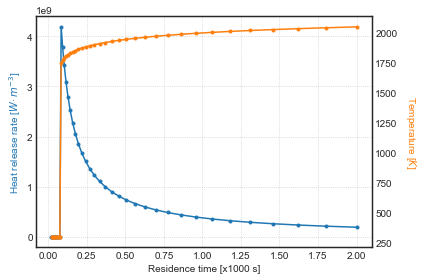

In [6]:
test_gri30()

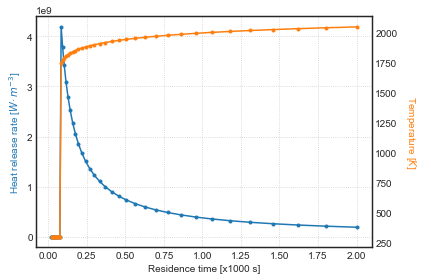

In [7]:
test_lu30_gri30()

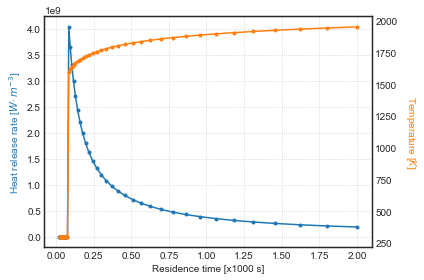

In [8]:
test_zhukov23_gri30()

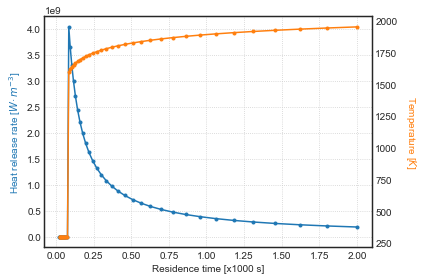

In [9]:
test_zhukov23_gri30_alt()

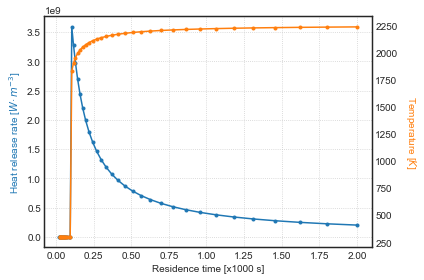

In [10]:
test_2s_ch4_bfer()